# Non alternating Behavior Policy

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


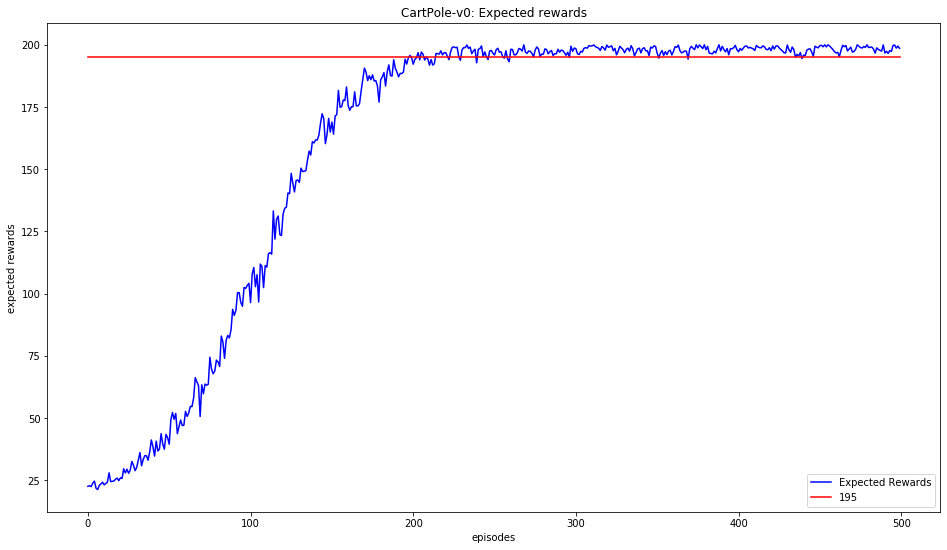

In [3]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
from queue import Queue
env = gym.make('CartPole-v0')
#having a min epsilon of 0.1 makes sure that no matter what there is some exploration so that if the epsilon decays too fast the enviornment is not dependent on its previous knowledge
class Qlearning:
    def __init__(self,bins=(1, 1, 6, 12), max_episodes = 500, max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> number of buckets for each action space
        #rather than 3 buckets for x and xdot, making it 1 makes it so that the state space dimentionalty is signifigantly reduced 
        # down-scaling feature space to discrete range
        #Since we assign only one bucket to the cart position and velocity, it means that we ignore these 2 values.
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.alpha = 1.0 # learning rate parameter
        self.beta = 0.5 # learning rate parameter
        self.epsilon = epsilon # exploration rate
        self.min_alpha = min_alpha
        self.min_epsilon = min_epsilon 
        self.solved = solved
        self.gamma = gamma
        self.decay = decay  #works for most numbers between 5 and 35
        self.action_space = action_space
        self.env = gym.make('CartPole-v0')
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q-matrix has now a dimension of (1 x 1 x 6 x 12 x 2).
        #print(self.QTable)
        
    def discretize(self, state):
        # observation = obs, reward, done, info = self.env.step(action)--> in training
        # define upper and lower bounds for each state value
        #it is necessary to give finite bounds and reduce the range of the cart velocity and pole velocity at tip – i.e. [-0.5, +0.5] and [-50, +50],
        #respectively – in order to be able to discretise.
        upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]  #UNDERSTAND HOW THIS WORKS
        lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
        descretizedList = list()
        for i in  range(len(state)): #state = tuple (0,0,X,X)--> aka the state space  #scaling factor
            #print(state)
            ratios = (state[i] + abs(upper_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) # (state+lower / bin_width) = bucket size
            #print(state[i] + abs(upper_bounds[i]))
            #print(ratios)
            new_obs = int(round((self.bins[i] - 1) * ratios)) #multiply the bucket size by the bucket # scaling the buckets so that the state is reduced#  - 1makes the first two buckets 0, and #bucket_lower := min_x + bucket × bucket size
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) 
            #no matter what the buckets-1 is going to be 0 or greater than 0 and within the index of the Q Lookup Table
            #this makes sure that the first two components of the tuple is 0
            descretizedList.append(new_obs)
        return tuple(descretizedList)

    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        #exploration-exploitation = np.random.random()
        #best = np.argmax(self.QTable[state])
        #random = env.action_space.sample()  # select a random action (see https://github.com/openai/gym/wiki/CartPole-v0) # exploration
        if np.random.random() <= epsilon:
            action = self.env.action_space.sample()   
        else:
            action = np.argmax(self.QTable[state])  # exploitation
            #print("best state", np.argmax(self.QTable[state]))
        return action

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        #print(self.QTable)
    # Q- values updates - Qk+1(s,a) = Qk(s,a) + alpha[R(s, a, s')+ gamma(maxQk(s,a,))- Qk(s,a)]
        # Updating Q-value of state-action pair based on the update equation - exploration rate
    
    """def decay_epsilon(self, t): 
        #print(max(self.min_epsilon, min(1, 1.0 - math.log((t + 1) / self.decay), math.e)))  #decay cannot be 1 or it decays too fast and the system doesn't explore enough
        return max(self.min_epsilon, min(1, 1.0 - math.log((t + 1) / self.decay), math.e))  #works with logbase10 as well???"""
    
    def decay_epsilon(self):
        epsilon = self.epsilon * 0.99
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon 

    """def decay_step_size(self, t):
           ##### DIMINISHING STEP SIZES ####
        #print(max(self.min_alpha, min(1.0, 1.0 - math.log10((t + 1) / self.decay)))) #log(timestep*decayrate)
        return max(self.min_alpha, min(1.0, 1.0 - math.log((t + 1) / self.decay), math.e)) """
    
    def decay_step_size(self, t):
        num = self.alpha
        dem = t**self.beta
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = num / dem  
        return step_size
    
#1-ln(time unit/decay)
def learning(Qlearning, bins=(1, 1, 6, 12), max_episodes = 400, max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n):
    listof100 = deque(maxlen=100) #https://stackoverflow.com/questions/5944708/python-forcing-a-list-to-a-fixed-size
    rewards = []
    alphaList = []
    epsilonList = []
    #episodes = []
    # this part until the end of the while loop:
    # this is the part of the function that trains the enviornment.
    for e in range(max_episodes):  
        # As states are continuous, discretize them into buckets
        # for each episode the enviornment resets and discretizes the state
        state = Qlearning.discretize(env.reset())
        #epsilon = self.epsilon
        epsilon = Qlearning.decay_epsilon() #e)
        #print("epsilon", epsilon)
        step_size = 1 #self.decay_step_size(e)
        #print("alpha", alpha)
        i = 0
        for t in range(max_steps):
            step_size = Qlearning.decay_step_size(t)
            action = Qlearning.action(state, epsilon) #, epsilon)
            new_state, reward, done, info = env.step(action)
            #print(new_state)
            new_state = Qlearning.discretize(new_state)
            Qlearning.Q_Update(state, action, reward, new_state, step_size)
            state = new_state
            i += 1
            #print(np.argwhere(self.QTable>=0))
            if done:
                break
        listof100.append(i)
        mean_listof100 = np.mean(listof100)
        rewards.append(i)
        alphaList.append(step_size)
        epsilonList.append(epsilon)
        mean_rewards =  np.mean(rewards)
    #print(self.QTable)
    return rewards, alphaList, epsilonList
    


if __name__ == '__main__':
    ''' Run main program. '''
    #solve = Qlearning()
    #rewards, alpha, epsilon = learning(solve, max_episodes = 500, bins=(1, 1, 6, 12), max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n)
    trajectory = [] 
    listof_195 = []
    for episode in range(500):
        listof_195.append(195)
    for i in range(100):
        solve = Qlearning()
        rewards, alpha, epsilon = learning(solve, max_episodes = 500, bins=(1, 1, 6, 12), max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n)
        trajectory.append(rewards)
        #print(rewards)
        #print("alpha", alpha)
        print(i)
    a = np.array(trajectory)
    final = np.mean(a, axis=0)
    fig = plt.figure(figsize=(16,9))
    plt.plot(final, 
            color = 'b',
            label = 'Expected Rewards')
    plt.plot(listof_195,  # epsilon_hist,
             color='r',
             label='195')
    plt.legend(loc='best')
    plt.title('CartPole-v0: Expected rewards')
    plt.xlabel('episodes')
    plt.ylabel('expected rewards') 
    plt.show()
    """ #moving_ave = solve.moving_average(rewards) 
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(311)
    ax1.plot(epsilon,  # epsiloif __name__ == '__main__':n_hist,
             color='b',
             label='Epsilon')
    ax1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')
    ax2 = fig.add_subplot(312)
    ax2.plot(alpha,  # epsilon_hist,
             color='b',
             label='step size')
    ax2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')
    ax3 = fig.add_subplot(313)
    ax3.plot(rewards,  # epsilon_hist,
             color='b',
             label='rewards')
    ax3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    fig.subplots_adjust(hspace=0.7)
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    ax3.legend(loc='best')

    plt.show()"""

# Alternating Behavior Policy

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


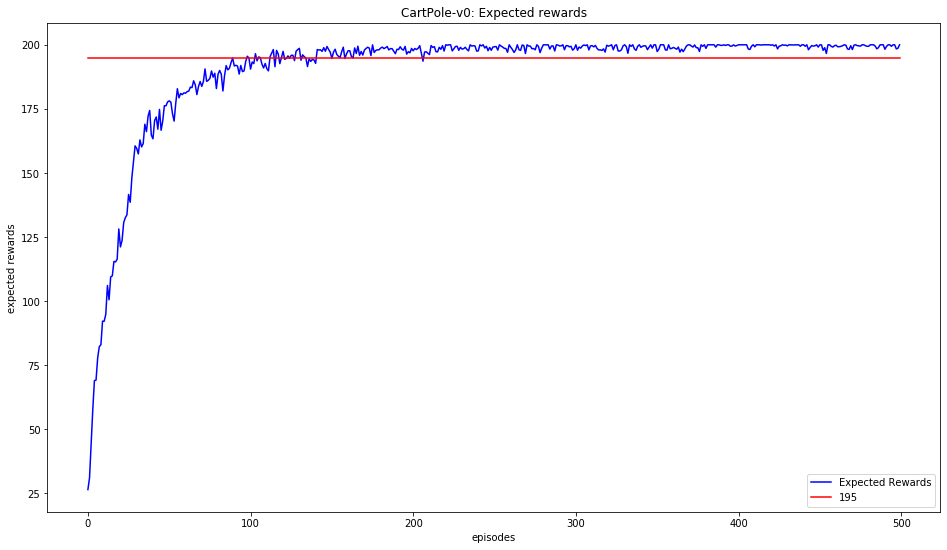

In [9]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
from queue import Queue
env = gym.make('CartPole-v0')
#having a min epsilon of 0.1 makes sure that no matter what there is some exploration so that if the epsilon decays too fast the enviornment is not dependent on its previous knowledge
class Qlearning:
    def __init__(self,bins=(1, 1, 6, 12), max_episodes = 1000, max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> number of buckets for each action space
        #rather than 3 buckets for x and xdot, making it 1 makes it so that the state space dimentionalty is signifigantly reduced 
        # down-scaling feature space to discrete range
        #Since we assign only one bucket to the cart position and velocity, it means that we ignore these 2 values.
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.alpha = 1.0 # learning rate parameter
        self.beta = 0.5 # learning rate parameter
        self.epsilon = epsilon # exploration rate
        self.min_alpha = min_alpha
        self.min_epsilon = min_epsilon 
        self.solved = solved
        self.gamma = gamma
        self.decay = decay  #works for most numbers between 5 and 35
        self.action_space = action_space
        self.env = gym.make('CartPole-v0')
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q-matrix has now a dimension of (1 x 1 x 6 x 12 x 2).
        #print(self.QTable)
        
    def discretize(self, state):
        # observation = obs, reward, done, info = self.env.step(action)--> in training
        # define upper and lower bounds for each state value
        #it is necessary to give finite bounds and reduce the range of the cart velocity and pole velocity at tip – i.e. [-0.5, +0.5] and [-50, +50],
        #respectively – in order to be able to discretise.
        upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]  #UNDERSTAND HOW THIS WORKS
        lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
        descretizedList = list()
        for i in  range(len(state)): #state = tuple (0,0,X,X)--> aka the state space  #scaling factor
            #print(state)
            ratios = (state[i] + abs(upper_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) # (state+lower / bin_width) = bucket size
            #print(state[i] + abs(upper_bounds[i]))
            #print(ratios)
            new_obs = int(round((self.bins[i] - 1) * ratios)) #multiply the bucket size by the bucket # scaling the buckets so that the state is reduced#  - 1makes the first two buckets 0, and #bucket_lower := min_x + bucket × bucket size
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) 
            #no matter what the buckets-1 is going to be 0 or greater than 0 and within the index of the Q Lookup Table
            #this makes sure that the first two components of the tuple is 0
            descretizedList.append(new_obs)
        return tuple(descretizedList)

    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        #exploration-exploitation = np.random.random()
        #best = np.argmax(self.QTable[state])
        #random = env.action_space.sample()  # select a random action (see https://github.com/openai/gym/wiki/CartPole-v0) # exploration
        if np.random.random() <= epsilon:
            action = self.env.action_space.sample()   
        else:
            action = np.argmax(self.QTable[state])  # exploitation
            #print("best state", np.argmax(self.QTable[state]))
        return action
    
    def action_policy(self, state, policy):
        return policy[state]
    
    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        #print(self.QTable)
    # Q- values updates - Qk+1(s,a) = Qk(s,a) + alpha[R(s, a, s')+ gamma(maxQk(s,a,))- Qk(s,a)]
        # Updating Q-value of state-action pair based on the update equation - exploration rate
    
    """def decay_epsilon(self, t): 
        #print(max(self.min_epsilon, min(1, 1.0 - math.log((t + 1) / self.decay), math.e)))  #decay cannot be 1 or it decays too fast and the system doesn't explore enough
        return max(self.min_epsilon, min(1, 1.0 - math.log((t + 1) / self.decay), math.e))  #works with logbase10 as well???"""
    
    def decay_epsilon(self):
        epsilon = self.epsilon * 0.99
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon 

    """def decay_step_size(self, t):
           ##### DIMINISHING STEP SIZES ####
        #print(max(self.min_alpha, min(1.0, 1.0 - math.log10((t + 1) / self.decay)))) #log(timestep*decayrate)
        return max(self.min_alpha, min(1.0, 1.0 - math.log((t + 1) / self.decay), math.e)) """
    
    def decay_step_size(self, t):
        num = self.alpha
        dem = t**self.beta
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = num / dem  
        return step_size
    
#1-ln(time unit/decay)
def learning(Qlearning, bins=(1, 1, 6, 12), max_episodes = 400, max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n):
    listof100 = deque(maxlen=100) #https://stackoverflow.com/questions/5944708/python-forcing-a-list-to-a-fixed-size
    rewards = []
    alphaList = []
    epsilonList = []
    #episodes = []
    # this part until the end of the while loop:
    # this is the part of the function that trains the enviornment.
    for e in range(max_episodes):  
        # As states are continuous, discretize them into buckets
        # for each episode the enviornment resets and discretizes the state
        state = Qlearning.discretize(env.reset())
        #epsilon = self.epsilon
        epsilon = Qlearning.decay_epsilon() #e)
        #print("epsilon", epsilon)
        step_size = 1 #self.decay_step_size(e)
        #print("alpha", alpha)
        i = 0
        for t in range(max_steps):
            step_size = Qlearning.decay_step_size(t)
            if e%2==0:
                action = Qlearning.action(state, epsilon)
            elif e%2==1:
                action = Qlearning.action_policy(state, policy)
            new_state, reward, done, info = env.step(action)
            #print(new_state)
            new_state = Qlearning.discretize(new_state)
            Qlearning.Q_Update(state, action, reward, new_state, step_size)
            state = new_state
            i += 1
            #print(np.argwhere(self.QTable>=0))
            if done:
                break
        stateTuple = list()
        stateList = []
        actionsList = []
        states = []
        for list1 in Qlearning.QTable:
            for nextList in list1:
                for nextList1 in nextList:
                    for nextList2 in nextList1:
                        actions = np.argmax(nextList2)
                        actionsList.append(actions)
        observations = np.argwhere(Qlearning.QTable>=0)
        for obsList in observations:
            stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3])
            stateList.append(stateTuple)
        del stateList[1::2]
        policy = dict(zip(stateList, actionsList))
        if e%2==1:
            rewards.append(i)
            alphaList.append(step_size)
            epsilonList.append(epsilon)
    return rewards, alphaList, epsilonList
    


if __name__ == '__main__':
    ''' Run main program. '''
    #solve = Qlearning()
    #rewards, alpha, epsilon = learning(solve, max_episodes = 500, bins=(1, 1, 6, 12), max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n)
    trajectory = [] 
    listof_195 = []
    for i in range(100):
        solve = Qlearning()
        rewards, alpha, epsilon = learning(solve, max_episodes = 1000, bins=(1, 1, 6, 12), max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n)
        trajectory.append(rewards)
        #print(rewards)
        #print("alpha", alpha)
        print(i)
    for episode in range(len(rewards)):
        listof_195.append(195)
    a = np.array(trajectory)
    final = np.mean(a, axis=0)
    fig = plt.figure(figsize=(16,9))
    plt.plot(final, 
            color = 'b',
            label = 'Expected Rewards')
    plt.plot(listof_195,  # epsilon_hist,
             color='r',
             label='195')
    plt.legend(loc='best')
    plt.title('CartPole-v0: Expected rewards')
    plt.xlabel('episodes')
    plt.ylabel('expected rewards') 
    plt.show()
    """ #moving_ave = solve.moving_average(rewards) 
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(311)
    ax1.plot(epsilon,  # epsiloif __name__ == '__main__':n_hist,
             color='b',
             label='Epsilon')
    ax1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')
    ax2 = fig.add_subplot(312)
    ax2.plot(alpha,  # epsilon_hist,
             color='b',
             label='step size')
    ax2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')
    ax3 = fig.add_subplot(313)
    ax3.plot(rewards,  # epsilon_hist,
             color='b',
             label='rewards')
    ax3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    fig.subplots_adjust(hspace=0.7)
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    ax3.legend(loc='best')

    plt.show()"""

# Continually Diminishing

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


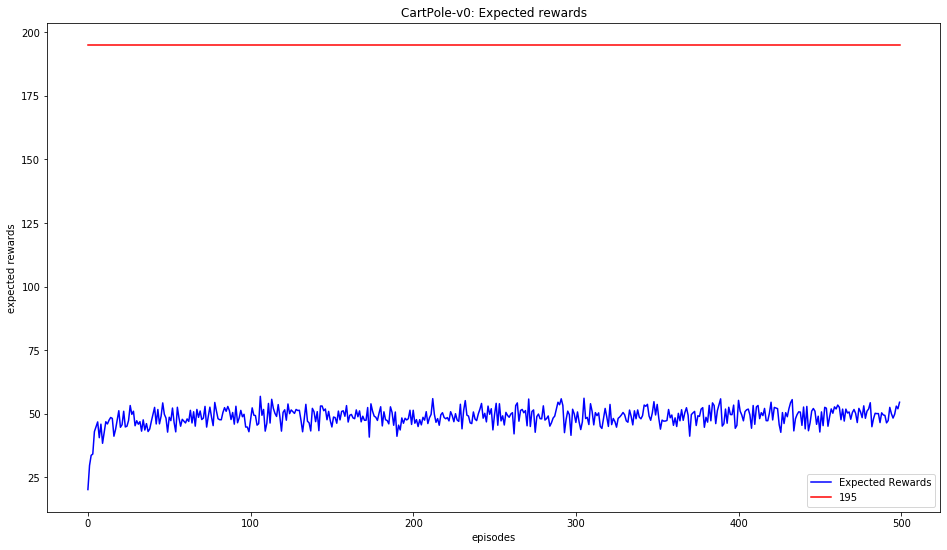

In [2]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
from queue import Queue
env = gym.make('CartPole-v0')
#having a min epsilon of 0.1 makes sure that no matter what there is some exploration so that if the epsilon decays too fast the enviornment is not dependent on its previous knowledge
class Qlearning:
    def __init__(self,bins=(1, 1, 6, 12), max_episodes = 1500, max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> number of buckets for each action space
        #rather than 3 buckets for x and xdot, making it 1 makes it so that the state space dimentionalty is signifigantly reduced 
        # down-scaling feature space to discrete range
        #Since we assign only one bucket to the cart position and velocity, it means that we ignore these 2 values.
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.alpha = 1.0 # learning rate parameter
        self.beta = 0.5 # learning rate parameter
        self.epsilon = epsilon # exploration rate
        self.min_alpha = min_alpha
        self.min_epsilon = min_epsilon 
        self.solved = solved
        self.gamma = gamma
        self.decay = decay  #works for most numbers between 5 and 35
        self.action_space = action_space
        self.env = gym.make('CartPole-v0')
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q-matrix has now a dimension of (1 x 1 x 6 x 12 x 2).
        
    def discretize(self, state):
        upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]  #UNDERSTAND HOW THIS WORKS
        lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
        descretizedList = list()
        for i in  range(len(state)): #state = tuple (0,0,X,X)--> aka the state space  #scaling factor
            ratios = (state[i] + abs(upper_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) # (state+lower / bin_width) = bucket size
            new_obs = int(round((self.bins[i] - 1) * ratios)) #multiply the bucket size by the bucket # scaling the buckets so that the state is reduced#  - 1makes the first two buckets 0, and #bucket_lower := min_x + bucket × bucket size
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) 
            descretizedList.append(new_obs)
        return tuple(descretizedList)

    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        #exploration-exploitation = np.random.random()
        #best = np.argmax(self.QTable[state])
        #random = env.action_space.sample()  # select a random action (see https://github.com/openai/gym/wiki/CartPole-v0) # exploration
        if np.random.random() <= epsilon:
            action = self.env.action_space.sample()   
        else:
            action = np.argmax(self.QTable[state])  # exploitation
            #print("best state", np.argmax(self.QTable[state]))
        return action
    
    def action_policy(self, state, policy):
        return policy[state]
    
    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        #print(self.QTable)
    
    def decay_epsilon(self):
        epsilon = self.epsilon * 0.99
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon 
    
    def decay_step_size(self, tt, e, t):
        num = self.alpha
        dem = tt**self.beta
        if e == 0 and t == 0:
            step_size = 1
        elif tt > 0:
            step_size = num / dem
        return step_size

def learning(Qlearning, bins=(1, 1, 6, 12), max_episodes = 400, max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n):
    listof100 = deque(maxlen=100) #https://stackoverflow.com/questions/5944708/python-forcing-a-list-to-a-fixed-size
    rewards = []
    alphaList = []
    epsilonList = []
    tt=0
    #episodes = []
    # this part until the end of the while loop:
    # this is the part of the function that trains the enviornment.
    for e in range(max_episodes):  
        # As states are continuous, discretize them into buckets
        # for each episode the enviornment resets and discretizes the state
        state = Qlearning.discretize(env.reset())
        #epsilon = self.epsilon
        epsilon = Qlearning.decay_epsilon() #e)
        #print("epsilon", epsilon)
        step_size = 1 #self.decay_step_size(e)
        #print("alpha", alpha)
        i = 0
        for t in range(max_steps):
            step_size = Qlearning.decay_step_size(tt,e,t)
            tt+=1
            if e%2==0:
                action = Qlearning.action(state, epsilon)
            elif e%2==1:
                action = Qlearning.action_policy(state, policy)
            new_state, reward, done, info = env.step(action)
            #print(new_state)
            new_state = Qlearning.discretize(new_state)
            Qlearning.Q_Update(state, action, reward, new_state, step_size)
            state = new_state
            i += 1
            #print(np.argwhere(self.QTable>=0))
            if done:
                break
        stateTuple = list()
        stateList = []
        actionsList = []
        states = []
        for list1 in Qlearning.QTable:
            for nextList in list1:
                for nextList1 in nextList:
                    for nextList2 in nextList1:
                        actions = np.argmax(nextList2)
                        actionsList.append(actions)
        observations = np.argwhere(Qlearning.QTable>=0)
        for obsList in observations:
            stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3])
            stateList.append(stateTuple)
        del stateList[1::2]
        policy = dict(zip(stateList, actionsList))
        if e%2==1:
            rewards.append(i)
            alphaList.append(step_size)
            epsilonList.append(epsilon)
    return rewards, alphaList, epsilonList
    


if __name__ == '__main__':
    ''' Run main program. '''
    #solve = Qlearning()
    #rewards, alpha, epsilon = learning(solve, max_episodes = 500, bins=(1, 1, 6, 12), max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n)
    trajectory = [] 
    listof_195 = []
    for i in range(100):
        solve = Qlearning()
        rewards, alpha, epsilon = learning(solve, max_episodes = 1000, bins=(1, 1, 6, 12), max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n)
        trajectory.append(rewards)
        #print(rewards)
        #print("alpha", alpha)
        print(i)
    for episode in range(len(rewards)):
        listof_195.append(195)
    a = np.array(trajectory)
    final = np.mean(a, axis=0)
    fig = plt.figure(figsize=(16,9))
    plt.plot(final, 
            color = 'b',
            label = 'Expected Rewards')
    plt.plot(listof_195,  # epsilon_hist,
             color='r',
             label='195')
    plt.legend(loc='best')
    plt.title('CartPole-v0: Expected rewards')
    plt.xlabel('episodes')
    plt.ylabel('expected rewards') 
    plt.show()
    """ #moving_ave = solve.moving_average(rewards) 
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(311)
    ax1.plot(epsilon,  # epsiloif __name__ == '__main__':n_hist,
             color='b',
             label='Epsilon')
    ax1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')
    ax2 = fig.add_subplot(312)
    ax2.plot(alpha,  # epsilon_hist,
             color='b',
             label='step size')
    ax2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')
    ax3 = fig.add_subplot(313)
    ax3.plot(rewards,  # epsilon_hist,
             color='b',
             label='rewards')
    ax3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    fig.subplots_adjust(hspace=0.7)
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    ax3.legend(loc='best')

    plt.show()"""

# Constant Step

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


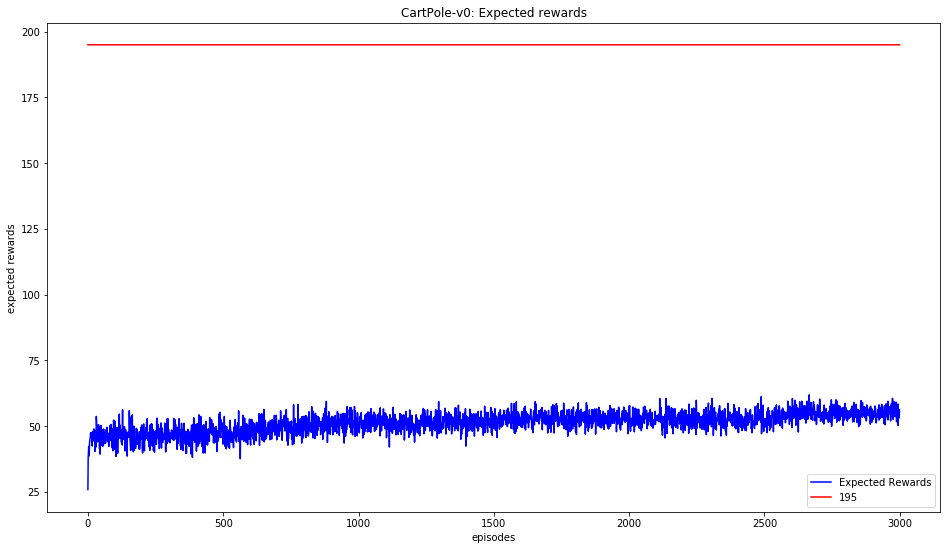

In [3]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
from queue import Queue
env = gym.make('CartPole-v0')
#having a min epsilon of 0.1 makes sure that no matter what there is some exploration so that if the epsilon decays too fast the enviornment is not dependent on its previous knowledge
class Qlearning:
    def __init__(self,bins=(1, 1, 6, 12), max_episodes = 5000, max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> number of buckets for each action space
        #rather than 3 buckets for x and xdot, making it 1 makes it so that the state space dimentionalty is signifigantly reduced 
        # down-scaling feature space to discrete range
        #Since we assign only one bucket to the cart position and velocity, it means that we ignore these 2 values.
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.alpha = 1.0 # learning rate parameter
        self.beta = 0.5 # learning rate parameter
        self.epsilon = epsilon # exploration rate
        self.min_alpha = min_alpha
        self.min_epsilon = min_epsilon 
        self.solved = solved
        self.gamma = gamma
        self.decay = decay  #works for most numbers between 5 and 35
        self.action_space = action_space
        self.env = gym.make('CartPole-v0')
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q-matrix has now a dimension of (1 x 1 x 6 x 12 x 2).
        #print(self.QTable)
        
    def discretize(self, state):
        # observation = obs, reward, done, info = self.env.step(action)--> in training
        # define upper and lower bounds for each state value
        #it is necessary to give finite bounds and reduce the range of the cart velocity and pole velocity at tip – i.e. [-0.5, +0.5] and [-50, +50],
        #respectively – in order to be able to discretise.
        upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]  #UNDERSTAND HOW THIS WORKS
        lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
        descretizedList = list()
        for i in  range(len(state)): #state = tuple (0,0,X,X)--> aka the state space  #scaling factor
            #print(state)
            ratios = (state[i] + abs(upper_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) # (state+lower / bin_width) = bucket size
            #print(state[i] + abs(upper_bounds[i]))
            #print(ratios)
            new_obs = int(round((self.bins[i] - 1) * ratios)) #multiply the bucket size by the bucket # scaling the buckets so that the state is reduced#  - 1makes the first two buckets 0, and #bucket_lower := min_x + bucket × bucket size
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) 
            #no matter what the buckets-1 is going to be 0 or greater than 0 and within the index of the Q Lookup Table
            #this makes sure that the first two components of the tuple is 0
            descretizedList.append(new_obs)
        return tuple(descretizedList)

    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        #exploration-exploitation = np.random.random()
        #best = np.argmax(self.QTable[state])
        #random = env.action_space.sample()  # select a random action (see https://github.com/openai/gym/wiki/CartPole-v0) # exploration
        if np.random.random() <= epsilon:
            action = self.env.action_space.sample()   
        else:
            action = np.argmax(self.QTable[state])  # exploitation
            #print("best state", np.argmax(self.QTable[state]))
        return action
    
    def action_policy(self, state, policy):
        return policy[state]
    
    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        #print(self.QTable)
    # Q- values updates - Qk+1(s,a) = Qk(s,a) + alpha[R(s, a, s')+ gamma(maxQk(s,a,))- Qk(s,a)]
        # Updating Q-value of state-action pair based on the update equation - exploration rate
    
    """def decay_epsilon(self, t): 
        #print(max(self.min_epsilon, min(1, 1.0 - math.log((t + 1) / self.decay), math.e)))  #decay cannot be 1 or it decays too fast and the system doesn't explore enough
        return max(self.min_epsilon, min(1, 1.0 - math.log((t + 1) / self.decay), math.e))  #works with logbase10 as well???"""
    
    def decay_epsilon(self):
        epsilon = self.epsilon * 0.99
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon 

    """def decay_step_size(self, t):
           ##### DIMINISHING STEP SIZES ####
        #print(max(self.min_alpha, min(1.0, 1.0 - math.log10((t + 1) / self.decay)))) #log(timestep*decayrate)
        return max(self.min_alpha, min(1.0, 1.0 - math.log((t + 1) / self.decay), math.e)) """
    
    def decay_step_size(self, t):
        num = self.alpha
        dem = t**self.beta
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = num / dem  
        return step_size
    
#1-ln(time unit/decay)
def learning(Qlearning, bins=(1, 1, 6, 12), max_episodes = 5000, max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n):
    listof100 = deque(maxlen=100) #https://stackoverflow.com/questions/5944708/python-forcing-a-list-to-a-fixed-size
    rewards = []
    alphaList = []
    epsilonList = []
    #episodes = []
    # this part until the end of the while loop:
    # this is the part of the function that trains the enviornment.
    for e in range(max_episodes):  
        # As states are continuous, discretize them into buckets
        # for each episode the enviornment resets and discretizes the state
        state = Qlearning.discretize(env.reset())
        #epsilon = self.epsilon
        epsilon = Qlearning.decay_epsilon() #e)
        #print("epsilon", epsilon)
        step_size = 0.01 #self.decay_step_size(e)
        #print("alpha", alpha)
        i = 0
        for t in range(max_steps):
            #step_size = Qlearning.decay_step_size(t)
            if e%2==0:
                action = Qlearning.action(state, epsilon)
            elif e%2==1:
                action = Qlearning.action_policy(state, policy)
            new_state, reward, done, info = env.step(action)
            #print(new_state)
            new_state = Qlearning.discretize(new_state)
            Qlearning.Q_Update(state, action, reward, new_state, step_size)
            state = new_state
            i += 1
            #print(np.argwhere(self.QTable>=0))
            if done:
                break
        stateTuple = list()
        stateList = []
        actionsList = []
        states = []
        for list1 in Qlearning.QTable:
            for nextList in list1:
                for nextList1 in nextList:
                    for nextList2 in nextList1:
                        actions = np.argmax(nextList2)
                        actionsList.append(actions)
        observations = np.argwhere(Qlearning.QTable>=0)
        for obsList in observations:
            stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3])
            stateList.append(stateTuple)
        del stateList[1::2]
        policy = dict(zip(stateList, actionsList))
        if e%2==1:
            rewards.append(i)
            alphaList.append(step_size)
            epsilonList.append(epsilon)
    return rewards, alphaList, epsilonList
    


if __name__ == '__main__':
    ''' Run main program. '''
    #solve = Qlearning()
    #rewards, alpha, epsilon = learning(solve, max_episodes = 500, bins=(1, 1, 6, 12), max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n)
    trajectory = [] 
    listof_195 = []
    for i in range(100):
        solve = Qlearning()
        rewards, alpha, epsilon = learning(solve, max_episodes = 6000, bins=(1, 1, 6, 12), max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n)
        trajectory.append(rewards)
        #print(rewards)
        #print("alpha", alpha)
        print(i)
    for episode in range(len(rewards)):
        listof_195.append(195)
    a = np.array(trajectory)
    final = np.mean(a, axis=0)
    fig = plt.figure(figsize=(16,9))
    plt.plot(final, 
            color = 'b',
            label = 'Expected Rewards')
    plt.plot(listof_195,  # epsilon_hist,
             color='r',
             label='195')
    plt.legend(loc='best')
    plt.title('CartPole-v0: Expected rewards')
    plt.xlabel('episodes')
    plt.ylabel('expected rewards') 
    plt.show()
